**FINANCIAL FRAUD DETECTION**
====

# Part 1: Reading the input data file and storing to DataFrame

In [6]:
from pyspark.sql.types import *
import sys
import os
sqlContext = SQLContext(sc)

###Read input file and convert it to RDD.
1. Read from file system
2. split columns
3. filter header
4. filter empty rows

In [7]:
filename = '/vagrant/PS_20174392719_1491204439457_log.csv'

def convertToTransactionSchema(arr):
    res = arr
    res[0] = int(arr[0]) # step
    res[2] = float(arr[2]) # amount
    res[4] = float(arr[4]) # old balance
    res[5] = float(arr[5]) # new balance
    res[7] = float(arr[7]) # old balance destination
    res[8] = float(arr[8]) # new balance destination
    res[9] = int(arr[9]) # is fraud
    res[10] = int(arr[10]) # is flagged fraud
    return res

transactionsRDD = (sc.textFile(filename)
       .map(lambda line: line.split(","))
       .filter(lambda line: line[0] != "step")
       .filter(lambda line: len(line)>1)
       .map(convertToTransactionSchema))
transactionsRDD.cache()

PythonRDD[5] at RDD at PythonRDD.scala:43

###Convert transactionsRDD into DataFrame and cache it.

In [8]:
transactionSchema = StructType([
    StructField("step", IntegerType(), True),
    StructField("type", StringType(), True),
    StructField("amount", FloatType(), True),
    StructField("nameOrig", StringType(), True),
    StructField("oldbalanceOrig", FloatType(), True),
    StructField("newbalanceOrig", FloatType(), True),
    StructField("nameDest", StringType(), True),
    StructField("oldbalanceDest", FloatType(), True),
    StructField("newbalanceDest", FloatType(), True),
    StructField("isFraud", IntegerType(), True),
    StructField("isFlaggedFraud", IntegerType(), True)])

transactionsDF = sqlContext.createDataFrame(transactionsRDD, transactionSchema)
transactionsDF.cache()
print transactionsDF.take(2)

[Row(step=1, type=u'PAYMENT', amount=9839.6396484375, nameOrig=u'C1231006815', oldbalanceOrig=170136.0, newbalanceOrig=160296.359375, nameDest=u'M1979787155', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0, isFlaggedFraud=0), Row(step=1, type=u'PAYMENT', amount=1864.280029296875, nameOrig=u'C1666544295', oldbalanceOrig=21249.0, newbalanceOrig=19384.720703125, nameDest=u'M2044282225', oldbalanceDest=0.0, newbalanceDest=0.0, isFraud=0, isFlaggedFraud=0)]


###Check if the DataFrame is cached.

In [5]:
transactionsDF.is_cached

NameError: name 'transactionsDF' is not defined

# Part 2: Data Cleaning

###The purpose of data cleaning is to check if there is any invalid or missing values, and eliminate those reords.

###Print the datatype for each column.

In [9]:
print transactionsDF.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: float (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrig: float (nullable = true)
 |-- newbalanceOrig: float (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: float (nullable = true)
 |-- newbalanceDest: float (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)

None


###We need to check each column for invalid values. The set of invalid values depends on the data type of the columns:
1. For columns with string type: empty or null values.
2. Otherwise: null or minus values.

###Firstly, we need to get columns that has 'string' datatype and store it in a variable.

In [6]:
stringCols = []
for (colName, colType) in transactionsDF.dtypes:
    if(colType == 'string'):
        stringCols.append(colName)
        
print stringCols

['type', 'nameOrig', 'nameDest']


###Then, we count the number of invalid values in each column and show the result.

In [11]:
from pyspark.sql.functions import *
from pyspark.sql import *
#from IPython.display import display

def isInvalidValue(colName):
    print(colName)
    if colName in stringCols:
        return (col(colName).isNull() | (col(colName) == ''))
    else:
        return (col(colName).isNull() | (col(colName) < 0))

transactionsDF.select([count(when(isInvalidValue(c), c)).alias(c) for c in transactionsDF.columns]).show()

step
type
amount
nameOrig
oldbalanceOrig
newbalanceOrig
nameDest
oldbalanceDest
newbalanceDest
isFraud
isFlaggedFraud
+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrig|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|             0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+--------------+--------------+--------+--------------+--------------+-------+--------------+



###As shown, the dataset does not contain any invalid values so we do not need to elminate any records.

## Part 3: Exploring the dataset

###First, we would explore some basic information in the dataset:

1. Number of fraudulent transactions
2. Types of the fraudulent transactions
3. What determines whether the feature isFlaggedFraud gets set or not?
4. Statistics of each column
5. Correllation analysis

### 1. Number and percentage of fraudulent transactions and show the records

In [10]:
fraudulentTransactions = transactionsDF.filter(transactionsDF.isFraud == 1)
fraudulentTransactions.show()
print "The total number of fraudulent records = ", fraudulentTransactions.count()
print "The percentage of fraudulent records = %f%%" % ( float(fraudulentTransactions.count())/transactionsDF.count()*100)

+----+--------+---------+-----------+--------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrig|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+--------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1|TRANSFER|    181.0|C1305486145|         181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|         181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1|TRANSFER|   2806.0|C1420196421|        2806.0|           0.0| C972765878|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   2806.0|C2101527076|        2806.0|           0.0|C1007251739|       26202.0|           0.0|      1|             0|
|   1|TRANSFER|  20128.0| C137533655|       20128.0|           0.0|C1

###2. Types of the fraudulent transactions

In [13]:
fraudulentTransactions.groupBy(fraudulentTransactions.type).count().show()

+--------+-----+
|    type|count|
+--------+-----+
|CASH_OUT| 4116|
|TRANSFER| 4097|
+--------+-----+



###We can see there are two fradulent types of transactions, `CASH_OUT` and `TRANSFER`.

###3. What determines whether the feature `isFlaggedFraud` gets set or not?
###In the overview of the dataset, `isFlaggedFraud` is defined as: "An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction." Now, we will check if the dataset agrees to the description given.

In [27]:
dfFlagged = transactionsDF.filter(transactionsDF.isFlaggedFraud == 1).cache()
flaggedTypes = dfFlagged.map(lambda x: x.type).distinct()
allTypes = transactionsDF.map(lambda x: x.type).distinct()

print('The transaction types available are: \n')
for t in allTypes.collect():
    print(t + '\n')

print('The type of transactions in which isFlaggedFraud is set:\n')
for t in flaggedTypes.collect():
    print(t + '\n')

The transaction types available are: 

TRANSFER

CASH_IN

DEBIT

PAYMENT

CASH_OUT

The type of transactions in which isFlaggedFraud is set:

TRANSFER



###Out of `TRANSFER`, `CASH_IN`, `DEBIT`, `PAYMENT`, and `CASH_OUT`, only `TRANSFER` type gets the `isFlaggedFraud` set as 1 (true). This still agrees with the description in the dataset overview. Now, we will check the minimum amount of money transferred in the transaction that has `isFlaggedFraud` set.

In [40]:
print('Minimum amount transferred when isFlaggedFraud is set: ' +
      str(dfFlagged.map(lambda x: x.amount).min()))

Minimum amount transferred when isFlaggedFraud is set: 353874.21875


###This result contradicts with the description that says any money transfer above 200,000 is flagged as fraud. Also, we already have another column `isFraud` which is the actual value whether or not the transaction is a fraud. This value should be the only benchmark and `isFlaggedFraud` is redundant, so we will drop this column.

DataFrame[step: int, type: string, amount: float, nameOrig: string, oldbalanceOrig: float, newbalanceOrig: float, nameDest: string, oldbalanceDest: float, newbalanceDest: float, isFraud: int]

###4. General Statistics
###Here are some general statistics to give us a better idea of how the data looks like. First, let's take a look at the distribution of transaction type.

In [50]:
# Prepare data to show transaction type distribution
groupedByTypes = transactionsDF.map(lambda x: (x.type, 1)).reduceByKey(lambda a, b: a + b)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = groupedByTypes.map(lambda (x, y): x).collect()
sizes = groupedByTypes.map(lambda (x, y): y).collect()

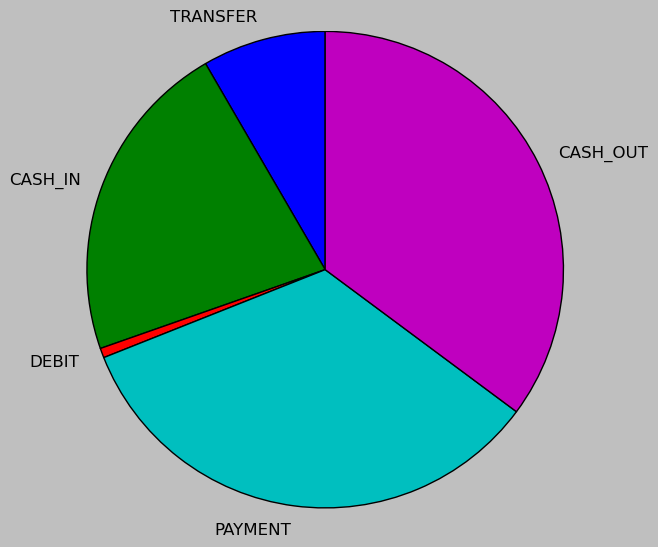

In [51]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

###Next we will look at the transaction amounts.

In [54]:
print('Statistics of all transaction amounts:')
transactionsDF.describe('amount').show()

+-------+------------------+
|summary|            amount|
+-------+------------------+
|  count|           6362620|
|   mean|179861.90355799912|
| stddev| 603858.2316772835|
|    min|               0.0|
|    max|        9.244552E7|
+-------+------------------+



In [9]:
print('Statistics of non-fraud transaction amounts:')
transactionsDF.filter(transactionsDF.isFraud == 1).describe('amount').show()

Statistics of non-fraud transaction amounts:
+-------+-----------------+
|summary|           amount|
+-------+-----------------+
|  count|             8213|
|   mean|1467967.299835128|
| stddev|2404252.947526678|
|    min|              0.0|
|    max|            1.0E7|
+-------+-----------------+



Here, we check if there is any correlation between fraudulent records and the originator of the transaction.

In [32]:
fraudTransactions = transactionsDF.filter(transactionsDF.isFraud == 1)
fraudOriginators = fraudTransactions.map(lambda x: (x.nameOrig, 1)).reduceByKey(lambda a, b: a + b)

In [33]:
print("How many originators had fraudulent transactions more than once? " + 
      str(fraudOriginators.filter(lambda (x, y): y > 1).count()))

print(fraudOriginators.collect())

How many originators had fraudulent transactions more than once? 0
[(u'C2146618198', 1), (u'C727140107', 1), (u'C1834671253', 1), (u'C610159138', 1), (u'C884840595', 1), (u'C1395548664', 1), (u'C323473080', 1), (u'C1983440446', 1), (u'C1414793795', 1), (u'C1563386305', 1), (u'C1342244082', 1), (u'C634089015', 1), (u'C1376413283', 1), (u'C366677925', 1), (u'C19004745', 1), (u'C411007033', 1), (u'C1961506277', 1), (u'C1482849004', 1), (u'C397247453', 1), (u'C1016616731', 1), (u'C328238019', 1), (u'C685396140', 1), (u'C1714764214', 1), (u'C7511880', 1), (u'C260785530', 1), (u'C299814057', 1), (u'C362205540', 1), (u'C226825556', 1), (u'C338054971', 1), (u'C1109518048', 1), (u'C1252081364', 1), (u'C1633390625', 1), (u'C1277761503', 1), (u'C1970706589', 1), (u'C411433616', 1), (u'C1936484732', 1), (u'C494904696', 1), (u'C99979309', 1), (u'C633635438', 1), (u'C1758753461', 1), (u'C338600181', 1), (u'C1751529795', 1), (u'C237098657', 1), (u'C199337547', 1), (u'C1888967333', 1), (u'C1876689114'

None of the originators had fraudulent transaction more than once, which means that this data cannot indicate the credibility of any of the originator. Now, we'll take a look at the destinations.

In [24]:
fraudTransactions = transactionsDF.filter(transactionsDF.isFraud == 1)
fraudRecipients = fraudTransactions.map(lambda x: (x.nameDest, 1)).reduceByKey(lambda a, b: a + b)

In [36]:
secondFraudRecipient = fraudRecipients.filter(lambda (x, y): y > 1)
noOfSecondFraudRecipient = secondFraudRecipient.count()

print("How many recipients had fraudulent transactions more than once? " + 
      str(noOfSecondFraudRecipient))

print("The percentage of recipients that get involved in fraudulent transaction more than once: " +
     str(noOfSecondFraudRecipient * 100.0 / fraudRecipients.count()) + "%")

How many recipients had fraudulent transactions more than once? 44
The percentage of recipients that get involved in fraudulent transaction more than once: 0.538621618313%


In [37]:
print(secondFraudRecipient.collect())

# for (name, count) in secondFraudRecipient.collect():
#     print("name: " + name + ", count: " + str(count) + "\n")

[(u'C2020337583', 2), (u'C475338087', 2), (u'C410033330', 2), (u'C104038589', 2), (u'C644163395', 2), (u'C1259079602', 2), (u'C105660024', 2), (u'C1497532505', 2), (u'C935310781', 2), (u'C1827219533', 2), (u'C1837027614', 2), (u'C1601170327', 2), (u'C967226405', 2), (u'C1366192319', 2), (u'C185805228', 2), (u'C2129197098', 2), (u'C1656842502', 2), (u'C686334805', 2), (u'C385133759', 2), (u'C650699445', 2), (u'C1981613973', 2), (u'C505532836', 2), (u'C1669818195', 2), (u'C668046170', 2), (u'C964377943', 2), (u'C1827800010', 2), (u'C1148781766', 2), (u'C904300960', 2), (u'C1193568854', 2), (u'C1655359478', 2), (u'C52390890', 2), (u'C1325541393', 2), (u'C1013511446', 2), (u'C1980653895', 2), (u'C803116137', 2), (u'C1650668671', 2), (u'C1185292292', 2), (u'C1780714769', 2), (u'C200064275', 2), (u'C643624257', 2), (u'C1399829166', 2), (u'C1460854172', 2), (u'C14138104', 2), (u'C1653587362', 2)]


Although some recipients are involved in more than 1 fraudulent transaction, it's only 0.5% of them. So, we conclude that there is no significant correlation between transaction destination and whether or not a transaction is fraudulent. Hence the column `nameDest` does not have much meaning.

### `nameOrig` and `nameDest` are not useful in predicting the fraudulent records unless we have extra data on the originators and receivers

In [ ]:
# Drop 'isFlaggedFraud'
categoricalTransactionsDF = transactionsDF.drop('isFlaggedFraud').drop('nameOrig').drop('nameDest')

## Part 4: Building up the fraud detection model

### To make the string columns categorical, they should be casted into double datatype first. 

In [53]:
indexer = StringIndexer(inputCol="type", outputCol="typeIndex").fit(categoricalTransactionsDF).transform(categoricalTransactionsDF)
indexer.show()

+----+--------+---------+--------------+--------------+--------------+--------------+-------+--------------+---------+
|step|    type|   amount|oldbalanceOrig|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|typeIndex|
+----+--------+---------+--------------+--------------+--------------+--------------+-------+--------------+---------+
|   1| PAYMENT|  9839.64|      170136.0|     160296.36|           0.0|           0.0|      0|             0|      1.0|
|   1| PAYMENT|  1864.28|       21249.0|      19384.72|           0.0|           0.0|      0|             0|      1.0|
|   1|TRANSFER|    181.0|         181.0|           0.0|           0.0|           0.0|      1|             0|      3.0|
|   1|CASH_OUT|    181.0|         181.0|           0.0|       21182.0|           0.0|      1|             0|      0.0|
|   1| PAYMENT| 11668.14|       41554.0|      29885.86|           0.0|           0.0|      0|             0|      1.0|
|   1| PAYMENT|  7817.71|       53860.0|      46

In [62]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


#TODO: remove labelindexer
labelIndexer = StringIndexer(inputCol="isFraud", outputCol="isFraudLabel")

featuresCols = indexer.columns
featuresCols.remove('isFraud')
featuresCols.remove('type')

featureAssembler = VectorAssembler(inputCols=featuresCols, outputCol="rawFeatures")
featureIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=5)
(trainingData, testData) = indexer.randomSplit([0.7, 0.3])

#TODO
randomForest = RandomForestClassifier(labelCol="isFraudLabel", featuresCol="features")
pipeline = Pipeline(stages=[labelIndexer, featureAssembler, featureIndexer, randomForest])
model = pipeline.fit(trainingData)


In [72]:
predictions = model.transform(testData)
predictions.show(5)

+----+-------+-------+--------------+--------------+--------------+--------------+-------+--------------+---------+------------+--------------------+--------------------+--------------------+--------------------+----------+
|step|   type| amount|oldbalanceOrig|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|typeIndex|isFraudLabel|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+----+-------+-------+--------------+--------------+--------------+--------------+-------+--------------+---------+------------+--------------------+--------------------+--------------------+--------------------+----------+
|   1|CASH_IN| 270.78|     4184966.8|     4185237.5|        3019.0|           0.0|      0|             0|      2.0|         0.0|[1.0,270.77999877...|[1.0,270.77999877...|[19.9945643610165...|[0.99972821805082...|       0.0|
|   1|CASH_IN| 911.76|     1335635.5|     1336547.2|       48321.6|      47409.85|      0|             0

In [70]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="isFraudLabel", predictionCol="prediction", metricName="precision")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.000735489


In [75]:
import graphviz 
graphviz(randomForest)

ImportError: No module named graphviz

###Spilting the dataset

In [26]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.util import MLUtils

trainingData, testData = transactionsRDD.randomSplit([0.7, 0.3])
print "There are %d training reords and %d test records." % (trainingData.count(), testData.count())
print "There are %d fraudulent records in the test data." % (testData.filter(transactionsDF.isFraud == 1))


There are 4455162 training reords and 1907458 test records.


## Part 5: Evaluating the fraud detection model

## Part 6: Analyzing the fraud detection model